# Experiment - CNN 2D with cross first

## Report
* Preprocessing 11 subjects (1-10), 6 runs (3, 4, 7, 8, 11, 12), filter 1-40, time 0s-4s, C3-C4 channels.
* T-min and T-max is the most impact with the result, choose a time that comprehensive all subject action.
* Learning rate is more impact, it works well when reduce lr.
* Adam optimizer with `0.00001` learning rate.
* CNN 2D, 2 layers (64, 128), batch norm.
* Reduce channel for expanding batch size and speed up running time, prevent out of memory also.

## 0. Importing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

## 1. Preprocessing

In [2]:
class EEG:
    def __init__(self, path, base_url, subjects, runs):
        self.subpath = 'MNE-eegbci-data/files/eegmmidb/1.0.0'
        self.path = path
        self.base_url = base_url
        self.subjects = subjects
        self.runs = runs
        
        # download data if does not exist in path.
        self.load_data()
        self.data_to_raw()
    
    def load_data(self):
        print(f">>> Start download from: {self.base_url}.")
        print(f"Downloading files to: {self.path}.")
        for subject in self.subjects:
            eegbci.load_data(subject,self.runs,path=self.path,base_url=self.base_url)
        print("Done.")
    
    def data_to_raw(self):
        fullpath = os.path.join(self.path, *self.subpath.split(sep='/'))
        print(f">>> Extract all subjects from: {fullpath}.")
        extension = "edf"
        raws = []
        raw_subjects = []
        count = 1
        for i, subject in enumerate(self.subjects):
            sname = f"S{str(subject).zfill(3)}".upper()
            raw_subject = []
            for j, run in enumerate(self.runs):
                rname = f"{sname}R{str(run).zfill(2)}".upper()
                path_file = os.path.join(fullpath, sname, f'{rname}.{extension}')
                print(f"Loading file #{count}/{len(self.subjects)*len(self.runs)}: {f'{rname}.{extension}'}")
                raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
                raws.append(raw)
                raw_subject.append(raw)
                count += 1
            raw_subjects.append(mne.io.concatenate_raws(raw_subject))

        raw = mne.io.concatenate_raws(raws)         # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)
        self.raw = raw
        # set montage to raw of all subjects
        for r in raw_subjects:
            eegbci.standardize(r)
            r.set_montage(montage)
        self.raw_subjects = raw_subjects
        print("Done.")
    
    def filter(self, freq):
        low, high = freq
        print(f">>> Apply filter.")
        self.raw.filter(low, high, fir_design='firwin', verbose=20)
        
    def get_events(self, raw, verbose=None):
        event_id = dict(T1=0, T2=1) # the events we want to extract
        events, event_id = mne.events_from_annotations(raw, event_id=event_id, verbose=verbose)
        return events, event_id
    
    def get_epochs(self, raw, events, event_id, tmin=-1, tmax=4, verbose=None):
        picks = mne.pick_types(raw.info, eeg=True, exclude='bads')
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, 
                            picks=picks, baseline=None, preload=True, verbose=verbose)
        return epochs
    
    def create_epochs(self, tmin=-1, tmax=4):
        print(">>> Creating Epochs.")
        events, event_id = self.get_events(self.raw)
        self.epochs = self.get_epochs(self.raw, events, event_id, tmin, tmax)
        self.epochs_subjects = []
        
        print(">>> Creating Epochs each subjects.")
        for r in self.raw_subjects:
            r_events, r_event_id = self.get_events(r, verbose=False)
            r_e = self.get_epochs(r, events, event_id, tmin, tmax, verbose=False)
            self.epochs_subjects.append(r_e)
        print("Done.")
    
    def get_X_y(self, tmin=-1, tmax=4):
        if self.epochs is None:
            self.create_epochs(tmin, tmax)
        self.X = self.epochs.get_data()
        self.y = self.epochs.events[:, -1]
        return self.X, self.y
    
    def get_X_y_each_subject(self, tmin=-1, tmax=4):
        if self.epochs is None:
            self.create_epochs(tmin, tmax)
        X = []
        y = []
        for e in self.epochs_subjects:
            X_t = e.get_data()
            y_t = e.events[:, -1]
            X.append(X_t)
            y.append(y_t)
        return X, y

In [3]:
# home directory + datasets folder
path = os.path.join(os.path.expanduser("~"), 'datasets')
base_url = 'https://physionet.org/files/eegmmidb/1.0.0/'
# runs = [3, 7]
# runs = [6,10,14]
runs = [3, 4, 7, 8, 11, 12]
subjects = [i for i in range(1, 11)]

eeg = EEG(path, base_url, subjects, runs)

# apply filter
freq = (1., 40.)
eeg.filter(freq=freq)

eeg.create_epochs(tmin=0, tmax=4)

>>> Start download from: https://physionet.org/files/eegmmidb/1.0.0/.
Done.
>>> Extract all subjects from: C:\Users\supha\datasets\MNE-eegbci-data\files\eegmmidb\1.0.0.
Loading file #1/60: S001R03.edf
Loading file #2/60: S001R04.edf
Loading file #3/60: S001R07.edf
Loading file #4/60: S001R08.edf
Loading file #5/60: S001R11.edf
Loading file #6/60: S001R12.edf
Loading file #7/60: S002R03.edf
Loading file #8/60: S002R04.edf
Loading file #9/60: S002R07.edf
Loading file #10/60: S002R08.edf
Loading file #11/60: S002R11.edf
Loading file #12/60: S002R12.edf
Loading file #13/60: S003R03.edf
Loading file #14/60: S003R04.edf
Loading file #15/60: S003R07.edf
Loading file #16/60: S003R08.edf
Loading file #17/60: S003R11.edf
Loading file #18/60: S003R12.edf
Loading file #19/60: S004R03.edf
Loading file #20/60: S004R04.edf
Loading file #21/60: S004R07.edf
Loading file #22/60: S004R08.edf
Loading file #23/60: S004R11.edf
Loading file #24/60: S004R12.edf
Loading file #25/60: S005R03.edf
Loading file #2

## 2. Prepare Data

In [4]:
X, y = eeg.get_X_y()

print(X.shape, y.shape)

X = X[:, np.newaxis,:,:]
X.shape

(1615, 64, 641) (1615,)


(1615, 1, 64, 641)

In [5]:
# pick 7 channels.
# X2 = X[:, :, 7:14, :]
# X = X2

# pick C3 and C4 channels.
# X2 = X[:, :, 1:2, :] 
# X3= X[:, :, 5:6, :]
# X4 = np.concatenate((X2,X3), axis=2)
# X = X4

print(X.shape)

(1615, 1, 64, 641)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)

(1292, 1, 64, 641) (1292,)


In [7]:
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

In [8]:
batch_size = 32
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [9]:
for i, (images, label) in enumerate(train_loader):
    print(images.shape)
    break

torch.Size([32, 1, 64, 641])


## 3. Modeling

In [10]:
#set gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(327680, 2)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [12]:
model = ConvNet().to(device)

In [13]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=327680, out_features=2, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
)

In [14]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

## 4. Training & Testing

In [15]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid

epoch 200/200 train loss: 0.00324 train acc: 100.0 validation loss: 0.28845 validation acc: 93.80805206298828


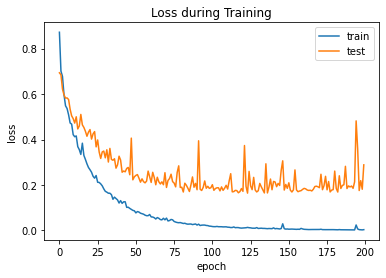

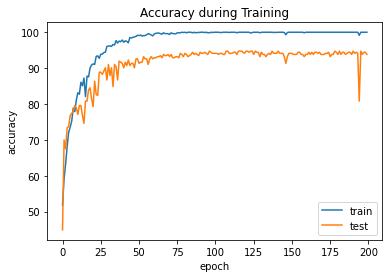

In [16]:
model, loss_train, loss_valid, acc_train, acc_valid = train_model(
    model,
    train_loader,
    test_loader,
    200,
    criterion,
    optimizer,
    10
)